# Does the HI-morphology connection vary with envrionment?

According to [Cooper et al. 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.383.1058C/abstract), the $\delta_5$ parameter, or overdensity calculated by finding normalized surface density to the fifth nearest neighbor (within $\pm$1,000 km/s), is a good way to parameterize environment.

I've made catalogs of $\delta_5$ overdensity for ALFALFA and xGASS. I also verified that the latter's `ENV_CODE_B` categorization correlates somewhat with $\delta_5$.

Note that the $\delta_5$ parameter suffers from edge effects at $z \lesssim 0.053$ (since the NSA redshift edge is $z = 0.055$).

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai import *
from fastai.vision import *

import seaborn as sns

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

seed = 12345

/content/drive/My Drive/alfalfa-convnets


In [3]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


## Compute $\delta_5$

In [12]:
df = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

df = df.join(pd.read_csv(f"{PATH}/data/xGASS-delta_5.csv", index_col="GASS"), on="GASS", rsuffix='_GASS')
df['logfgas'] = df.lgMHI - df.lgMstar

display(df.sample(2), len(df))

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB,delta_5,logfgas
738,113000,231342,J131936.84+030157.3,526,52312,413,199.90353,3.03260,0.019746,85.9,10.072838,0.761388,14.1193,0.0020,0.0683,4.16,12.02,3.98,8.87,2.89,41.4,2.92,0.307823,1.832144,0.197984,1,1,0,0,0.019700,250.0,9.400,-0.673,0.0,0.655,21352,289410,2,2,0,11.7339,-1.642275,0.236289,-0.672838
255,109134,0,J091313.69+114616.7,2576,54086,76,138.30708,11.77132,0.016737,72.6,9.430802,0.461498,16.6025,0.0042,0.0823,2.64,7.13,2.50,8.77,2.70,64.9,3.76,-0.592023,0.226122,0.116018,1,3,1,4,0.016685,241.0,8.688,-0.743,0.0,2.356,470254,2498616,1,1,0,0.0000,-99.000000,0.294303,-0.742802


1179

In [0]:
def split_isolated(df, reverse=False):
    """Add boolean column that is True if delta_5 is less than 20th percentile.

    If reverse=False, then the highest density galaxies are split out into this
    new column.
    """

    df['isolated'] = ((df.delta_5 < df.delta_5.quantile(q=0.2)) \
                      if not reverse \
                      else (df.delta_5 > df.delta_5.quantile(q=0.8)))

    return df

In [0]:
bs = 64
sz = 224

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# Split xGASS

## $\delta_5$ Environment split (validation = underdense)

In [0]:
# run the split above
df = split_isolated(df)

src = (
    ImageList.from_df(
        df, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
    )
    .split_from_df(col='isolated') # isolated -> validation
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

In [0]:
data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
# learn.fit(1, 1e-4)

In [0]:
learn.fit_one_cycle(40, 10e-2, )

epoch,train_loss,valid_loss,time
0,1.246683,0.964450,00:08
1,1.077469,0.758217,00:06
2,0.875420,0.684390,00:06
3,0.712145,0.665115,00:06
4,0.620643,0.595358,00:06
5,0.552228,0.822492,00:06
6,0.505011,0.459144,00:06
7,0.478001,0.637252,00:06
8,0.453833,1.203428,00:06
9,0.439957,0.430985,00:06


In [0]:
# learn.save('xgass-sdss_d5-1')
learn.load('xgass-sdss_d5-1');

set state called


Looks like we can get down to ~0.33 using a $\delta$

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.3313)

    TTA results
    0.3313
    0.3392
    0.3228
    0.3352
    0.3251

Mean: 0.3307, Std: 0.0061

## $\delta_5$ split: validate on overdense 

In [0]:
# run the split above
df = split_isolated(df, reverse=True)

src = (
    ImageList.from_df(
        df, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
    )
    .split_from_df(col='isolated') # isolated -> validation
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)
data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
learn.fit_one_cycle(40, 10e-2,)

epoch,train_loss,valid_loss,time
0,1.074239,1.485532,00:07
1,0.934774,1.239254,00:06
2,0.758373,0.671295,00:06
3,0.636147,0.641398,00:06
4,0.559329,2.744791,00:06
5,0.505695,0.460059,00:06
6,0.470496,0.439845,00:06
7,0.444497,0.517127,00:06
8,0.435432,0.501480,00:06
9,0.423376,0.470481,00:06


In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.3458)

(lr = 1e-1, 40 epochs)

    TTA stats
    0.3439
    0.3466
    0.3369
    0.3451
    0.3396

Mean = 0.3424, Std = 0.0036

In [0]:
tta_stats = [0.3439, 0.3466, 0.3369, 0.3451, 0.3396]
np.mean(tta_stats), np.std(tta_stats)

(0.34242, 0.0036129766121579137)

## Random split 

In [0]:
df = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

df = df.join(pd.read_csv(f"{PATH}/data/xGASS-delta_5.csv", index_col="GASS"), on="GASS", rsuffix='_GASS')
df['logfgas'] = df.lgMHI - df.lgMstar

In [0]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
learn.fit_one_cycle(40, 10e-2, )

epoch,train_loss,valid_loss,time
0,1.156492,1.192439,00:07
1,1.006644,0.958354,00:07
2,0.822324,0.545855,00:07
3,0.679603,0.904882,00:07
4,0.594791,0.427058,00:07
5,0.534125,0.404791,00:07
6,0.497528,0.873382,00:07
7,0.470667,0.884665,00:07
8,0.454715,0.334283,00:07
9,0.436680,1.164517,00:07


In [0]:
# learn.save('xgass-sdss_rand-1')
# learn.load('xgass-sdss_rand-1');

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2895)

Oh interesting, that's way better. RMSE ~ 0.29 dex


Using lr=6e-2, bs=64, training for 40 epochs.

    TTA results
    0.2884
    0.2915
    0.2855
    0.2871
    0.2895

In [0]:
tta_stats = [0.2884, 0.2915, 0.2855, 0.2871, 0.2895, ]

np.mean(tta_stats), np.std(tta_stats)

(0.28839999999999993, 0.0020454828280872914)

# ALFALFA $\alpha.40$

## Environmental split (validate on underdense galaxies)

In [0]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_galaxy-properties.csv")

df = df.join(pd.read_csv(f"{PATH}/data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')

In [0]:
# again use delta_5 to split
df = split_isolated(df)

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,delta_5,isolated
4127,10426,733567,587739459375137112,9.51,9.211514,-0.543866,8.553057,0.298486,-9.755380,0.556528,True
247,1237,181721,587735348547945130,10.14,9.886497,-0.244543,8.847794,0.253503,-10.131040,2.026865,False
438,1739,184315,587738946663809178,9.20,9.152494,-1.148630,8.404551,0.047506,-10.301124,2.425880,False


In [0]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_from_df(col='isolated')
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
learn.fit_one_cycle(40, 10e-2, )

epoch,train_loss,valid_loss,time
0,0.420006,0.380387,00:34
1,0.336199,0.375149,00:34
2,0.308844,0.325081,00:34
3,0.298475,0.290801,00:34
4,0.302805,0.350555,00:35
5,0.302272,0.424602,00:35
6,0.308153,0.747370,00:36
7,0.313410,0.447867,00:36
8,0.310126,0.751913,00:36
9,0.304063,0.476307,00:36


In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2424)

    TTA stats
    0.2397
    0.2383
    0.2399
    0.2390
    0.2424

Mean: 0.2399, Std: 0.0014

In [0]:
tta_stats = [0.2397, 0.2383, 0.2399, 0.2390, 0.2424]

np.mean(tta_stats), np.std(tta_stats)

(0.23986000000000002, 0.0013893883546366728)

## $\alpha.40$ Validate on overdense

In [0]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_galaxy-properties.csv")

df = df.join(pd.read_csv(f"{PATH}/data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')

# reversed delta_5
df = split_isolated(df, reverse=True)

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,delta_5,isolated
4226,10645,253982,587736546312978790,10.01,9.548105,0.011273,8.809116,0.461895,-9.536832,5.856225,True
3612,9168,726347,587739457222541399,9.71,9.485456,-0.037500,8.890221,0.224544,-9.522956,1.458291,False
844,2776,191540,587741392111075571,9.76,10.509170,0.792400,9.150070,-0.749170,-9.716770,0.840205,False


In [0]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_from_df(col='isolated')
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
learn.fit_one_cycle(40, 10e-2, )


epoch,train_loss,valid_loss,time
0,0.399204,0.427217,00:35
1,0.334975,0.392969,00:35
2,0.305913,0.576713,00:35
3,0.296810,0.380868,00:35
4,0.292169,0.305960,00:35
5,0.292492,0.385572,00:35
6,0.294772,0.725333,00:35
7,0.294271,0.310617,00:35
8,0.298089,0.495683,00:35
9,0.297071,0.441151,00:35


In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2877)

    TTA stats
    0.2834
    0.2848
    0.2859
    0.2856
    0.2877

Mean: 0.2855, Std: 0.0014


In [0]:
tta_stats = [0.2834, 0.2848, 0.2859, 0.2856, 0.2877]

np.mean(tta_stats), np.std(tta_stats)

(0.28548000000000007, 0.0014076931483814298)

##  $\alpha.40$ Random split

In [0]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

In [0]:
# learn.fit(1)

In [0]:
learn.fit_one_cycle(40, 10e-2, )

epoch,train_loss,valid_loss,time
0,0.405320,0.604283,00:32
1,0.342985,0.375515,00:32
2,0.315508,0.492705,00:32
3,0.304062,0.297914,00:32
4,0.298909,0.493932,00:32
5,0.295999,0.306194,00:32
6,0.294244,0.310070,00:32
7,0.294974,0.622721,00:32
8,0.297522,0.659493,00:32
9,0.295306,0.409031,00:32


In [0]:
# learn.save('a40-sdss_d5-1')
# learn.load('a40-sdss_d5-1');

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2427)

lr = 1e-1, bs = 64, 40 epochs

    Best single epoch  TTA results
       ???               0.2441
       0.2415            0.2448
       0.2414            0.2444
       0.2406            0.2448
       0.2402            0.2427

Mean: 0.2442, Std: 0.0008

In [0]:
tta_stats = [.2441, .2448, .2444, .2448, .2427]
np.mean(tta_stats), np.std(tta_stats)

(0.24416000000000002, 0.0007761443164772874)

# Correlations between $\delta_5$ and other variables

## xGASS 

In [0]:
df = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

df = df.join(pd.read_csv(f"{PATH}/data/xGASS-delta_5.csv", index_col="GASS"), on="GASS", rsuffix='_GASS')
df['logfgas'] = df.lgMHI - df.lgMstar

df.sample(3)

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB,delta_5,logfgas
936,41703,714221,J144119.18+085256.5,1813,53903,526,220.32993,8.88236,0.029450,129.0,10.163000,0.568923,15.4097,0.0029,0.0735,3.04,9.44,2.98,8.87,3.11,57.1,3.78,-0.056688,0.476738,0.164515,1,3,2,2,0.029490,230.0,8.648,-1.515,0.0,0.564,291905,1343189,1,1,0,0.0000,-99.000000,2.095843,-1.515000
476,110081,202112,J105817.00+044732.1,580,52368,475,164.57086,4.79225,0.014451,62.6,9.518223,0.192891,15.7064,0.0045,0.1154,7.66,17.57,6.48,8.16,2.29,90.0,3.45,-1.241414,0.184802,0.113686,1,1,0,0,0.014530,258.0,9.130,-0.388,0.0,2.343,119422,449260,1,1,0,0.0000,-99.000000,0.072429,-0.388223
1117,11193,332480,J231321.76+141648.8,743,52262,38,348.34067,14.28022,0.039380,173.7,10.499000,0.295773,15.7624,0.0032,0.1887,2.75,6.76,2.46,9.14,2.46,77.2,5.42,0.334703,2.771787,0.326288,1,3,2,3,0.039671,354.0,8.804,-1.695,0.0,0.712,1391,349730,0,12,0,13.3589,-0.299049,4.232176,-1.695000


In [0]:
df['group'] = pd.Series(data=np.where(df.env_code_B == 1, 'isolated', 'group'))
df['group'].value_counts()

group       638
isolated    541
Name: group, dtype: int64

In [0]:
df['log_d5'] = np.log10(df.delta_5)

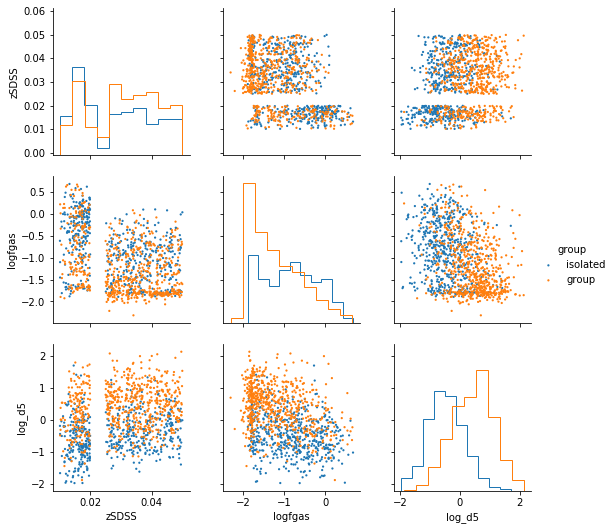

In [0]:
sns.pairplot(
    df,
    vars=['zSDSS', 'logfgas', 'log_d5'],
    diag_kind='hist',
    hue='group', 
    plot_kws={'s': 5, 'edgecolor': 'none'},
    diag_kws={'histtype': 'step'},
)
# x/ylabels should be 
# r'$z$', r'log($M_{\rm HI}/M_★$)', r'log($1+\delta_5$)'

In [0]:
df.zSDSS.max()

0.04997

## Check $\alpha.40$ for contamination between $\delta$ and other stuff, e.g., redshift

In [0]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_galaxy-properties.csv")

df = df.join(pd.read_csv(f"{PATH}/data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
df = df.join(pd.read_csv(f"{PATH}/data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')

df = df[df.z_sdss.notna()].copy()

df['log_d5'] = np.log10(df.delta_5)

# bottom 20%
df['isolated'] = np.where(df.log_d5 < df.log_d5.quantile(q=0.2), 'underdense', 'overdense')

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,delta_5,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err,log_d5,isolated
3705,9405,248941,587742611875168422,9.46,9.215815,-0.631788,8.678212,0.244185,-9.847603,0.998582,1,I,587742611875168422,7.731632e+17,15.82,1.58,0.02001,0.00025,-0.000616,overdense
1005,3165,203438,587732703399641296,9.50,9.403379,-0.631369,8.604847,0.096621,-10.034748,0.393530,1,I,587732703399641296,2.808570e+17,16.40,1.78,0.02621,0.00010,-0.405022,underdense
4181,10550,714752,587736477595926811,9.96,9.548282,-0.020988,8.792028,0.411718,-9.569270,1.021730,1,I,587736477595926811,4.840869e+17,15.83,1.40,0.03398,0.00009,0.009336,overdense


In [0]:
df.isolated.value_counts()

overdense     3836
underdense     957
Name: isolated, dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


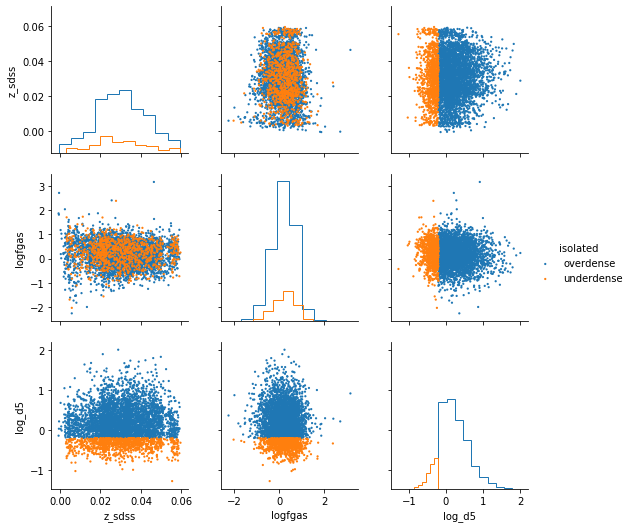

In [0]:
sns.pairplot(
    df,
    vars=['z_sdss', 'logfgas', 'log_d5'],
    diag_kind='hist',
    hue='isolated', 
    plot_kws={'s': 5, 'edgecolor': 'none'},
    diag_kws={'histtype': 'step'},
)

In [0]:
df['edge_z'] = np.where(df.z_sdss < 0.053, 'low-z', 'high-z')
df.edge_z.value_counts()

low-z     4574
high-z     219
Name: edge_z, dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


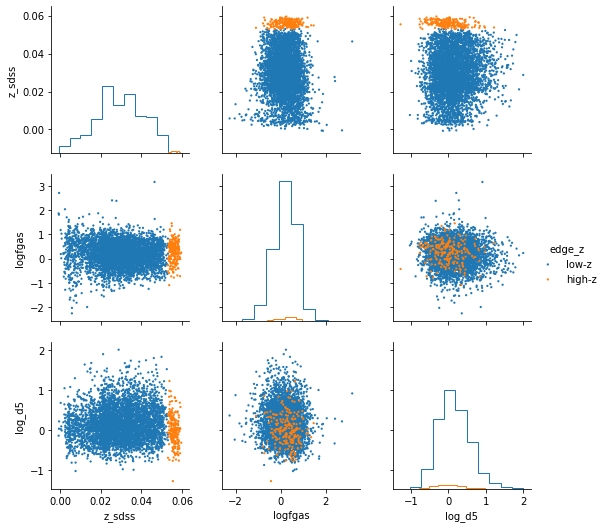

In [0]:
sns.pairplot(
    df,
    vars=['z_sdss', 'logfgas', 'log_d5'],
    diag_kind='hist',
    hue='edge_z', 
    plot_kws={'s': 5, 'edgecolor': 'none'},
    diag_kws={'histtype': 'step'},
)

# Re-train $\alpha.40$ except now with $z$ cut

In [0]:
def split_isolated(df, reverse=False):
    """Add boolean column that is True if delta_5 is less than 20th percentile.

    If reverse=False, then the highest density galaxies are split out into this
    new column.
    """

    df['isolated'] = ((df.delta_5 < df.delta_5.quantile(q=0.2)) \
                      if not reverse \
                      else (df.delta_5 > df.delta_5.quantile(q=0.8)))

    return df

In [17]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_galaxy-properties.csv")

df = df.join(pd.read_csv(f"{PATH}/data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
df = df.join(pd.read_csv(f"{PATH}/data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')

df = df[df.z_sdss < 0.05].copy()

df = split_isolated(df)

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,delta_5,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err,isolated
2853,7425,232715,588010879302828035,10.05,9.757505,-0.292345,8.738089,0.292495,-10.049850,1.544907,2,I,588010879302828035,2.391975e+17,16.60,1.80,0.04865,0.00010,False
874,2841,192649,587734862144077998,9.58,8.861965,-0.406265,8.281012,0.718035,-9.268230,0.542435,1,I,587734862144077998,3.478481e+17,16.86,1.15,0.03038,0.00008,True
4648,11782,260373,587736899038675063,9.93,10.797730,0.477665,9.185900,-0.867730,-10.320065,0.891193,1,I,587736899038675063,4.441158e+17,13.96,2.00,0.03327,0.00008,False


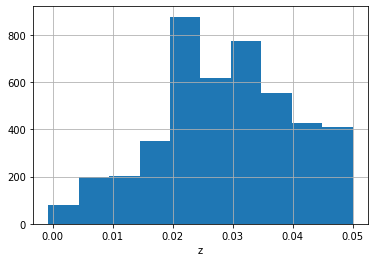

In [18]:
df.z_sdss.hist()
plt.xlabel("z");

In [19]:
df.isolated.value_counts()

False    3599
True      897
Name: isolated, dtype: int64

In [0]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_from_df(col='isolated')
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [0]:
# Train on overdense, validate on underdense
for i in range(5):
    learn = Learner(
        data,
        model=mxresnet34(),
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-3,
        bn_wd=False,
        true_wd=True,
    )

    learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

    learn.fit_one_cycle(40, 10e-2, )

    fgas_pred, fgas_true = learn.TTA(scale=1.)

    with open(f'{PATH}/results/environment/a40-valid-underdense.txt', 'a') as f:
        print('=================================================', file=f)
        print('ITERATION {:d} RMSE = {:.4f}'.format(i, root_mean_squared_error(fgas_pred, fgas_true)), file=f)
        print('=================================================', file=f)

In [22]:
validating_isolated = np.array([0.2443, 0.2419, 0.2405, 0.2424, 0.2418])
validating_isolated.mean(), validating_isolated.std()

(0.24217999999999998, 0.0012319090875547588)

In [26]:
# Train on underdense, validate on overdense

df = split_isolated(df, reverse=True)

for i in range(5):
    learn = Learner(
        data,
        model=mxresnet34(),
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-3,
        bn_wd=False,
        true_wd=True,
    )

    learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

    learn.fit_one_cycle(40, 10e-2, )

    fgas_pred, fgas_true = learn.TTA(scale=1.)

        print('=================================================', file=f)
        print('ITERATION {:d} RMSE = {:.4f}'.format(i, root_mean_squared_error(fgas_pred, fgas_true)), file=f)
        print('=================================================', file=f)

In [27]:
# random split

for i in range(5):
    src = (
        ImageList.from_df(
            df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
        )
        .split_by_rand_pct(0.2)         # do *not* make random seed constant
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    )

    data = (
        src.transform(tfms, size=sz)
        .databunch(bs=bs)
        .normalize(xGASS_stats)
    )

    learn = Learner(
        data,
        model=mxresnet34(),
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-3,
        bn_wd=False,
        true_wd=True,
    )

    learn.model[-1] = nn.Linear(learn.model[-1].in_features, 1, bias=True).cuda()

    learn.fit_one_cycle(40, 10e-2, )

    fgas_pred, fgas_true = learn.TTA(scale=1.)

    with open(f'{PATH}/results/environment/a40-valid-random.txt', 'a') as f:
        print('=================================================', file=f)
        print('ITERATION {:d} RMSE = {:.4f}'.format(i, root_mean_squared_error(fgas_pred, fgas_true)), file=f)
        print('=================================================', file=f)